BRAIN TUMOR DETECTION

IML PROJECT

Unzipping and Listing Dataset Files

In [ ]:
import zipfile


zip_path = 'brain_tumor_dataset.zip'

extract_path = '/content/brain_tumor_mri' #Unzipping the file to a specified directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


!ls /content/brain_tumor_mri


brain_tumor_dataset  __MACOSX


Installing TensorFlow Library

In [ ]:
!pip install tensorflow


Importing Libraries for Data Handling, Image Processing, and Model Building

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils
from os import listdir

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Flatten, Activation, Dense, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


Loading Image File Names for Tumor and Non-Tumor Classes

In [ ]:
image_dir = '/content/brain_tumor_mri/brain_tumor_dataset'
no_tumor_images = os.listdir(image_dir + '/no')
yes_tumor_images = os.listdir(image_dir + '/yes')

Setting Up Output Directory for Augmented Images

In [ ]:
# Output directory for augmented images
augmented_data_path = '/content/augmented-images'

# Creating the directory if it doesn’t exist
import os
os.makedirs(augmented_data_path, exist_ok=True)

print(f"Augmented images will be saved to: {augmented_data_path}")


Augmented images will be saved to: /content/augmented-images


 Creating Output Directories for Augmented Images by Class

In [ ]:
# Creating output directories if they don't exist
os.makedirs(augmented_data_path, exist_ok=True)
os.makedirs(os.path.join(augmented_data_path, 'yes'), exist_ok=True)
os.makedirs(os.path.join(augmented_data_path, 'no'), exist_ok=True)

Data Augmentation Function

In [ ]:
def augment_data(file_dir, n_generated_samples, save_to_dir):

    """
        file_dir: Directory containing the images to augment.
        n_generated_samples: Number of augmented images to generate per original image.
        save_to_dir: Directory to save the augmented images.
    """
    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for filename in os.listdir(file_dir):
        image = cv2.imread(os.path.join(file_dir, filename))
        image = image.reshape((1,) + image.shape)  # Reshape to (1, height, width, channels)

        # Generate augmented images and save them
        save_prefix = 'aug_' + filename[:-4]  # Remove the original file extension
        i = 0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,
                                  save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break




Data Augmentation Process for Brain Tumor MRI Dataset

In [ ]:
import os

# Main dataset directory
image_dir = '/content/brain_tumor_mri/brain_tumor_dataset'
augmented_data_path = '/content/augmented-images'


labels = {
    'yes': 6,       # Number of samples for tumorous images
    'no': 9     # Number of samples for non-tumorous images
}

# Creating the output directory if it doesn't exist
os.makedirs(augmented_data_path, exist_ok=True)

# Performing augmentation for each label
for label, n_samples in labels.items():
    file_dir = os.path.join(image_dir, label)

    # Checking if the directory exists just in case
    if not os.path.exists(file_dir):
        print(f"Directory not found: {file_dir}. Skipping this label.")
        continue

    save_to_dir = os.path.join(augmented_data_path, label)
    os.makedirs(save_to_dir, exist_ok=True)

    # augmentation
    augment_data(file_dir=file_dir, n_generated_samples=n_samples, save_to_dir=save_to_dir)


Brain Contour Cropping Function

In [ ]:


def crop_brain_contour(image, plot=False):

    """
    Crops the brain contour from an MRI image.

    Args:
        image: The input MRI image.
        plot: Whether to display the original and cropped images.

    Returns: The cropped image containing the brain contour.
    """

    # 1. Preprocessing: Grayscale, Blur, Threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # 2. Contour Detection and Extraction
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # 3. Extreme Points for Cropping
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # 4. Cropping
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    # 5. Optional Plotting
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')

        plt.show()

    return new_image

Example of Brain Contour Cropping

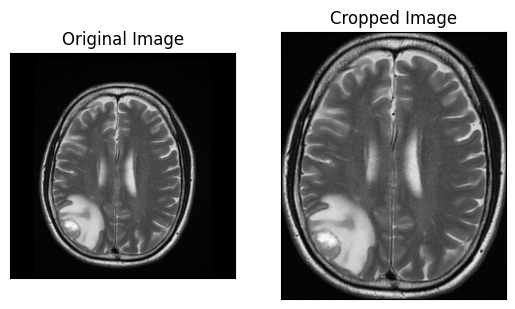

In [ ]:
#  (crop_brain_contour function )

ex_img = cv2.imread(os.path.join(image_dir, 'yes', 'Y107.jpg'))
ex_crop_img = crop_brain_contour(ex_img, True)

Data Loading and Preprocessing Function

In [ ]:
from os import listdir
def load_data(dir_list, image_size):

    """
    Loads and preprocesses image data from the specified directories.

    Args:
        dir_list: A list of directories containing the images.
        image_size: A tuple (width, height) specifying the desired image size.

    Returns:
        X: A NumPy array containing the preprocessed images.
        y: A NumPy array containing the corresponding labels where for 'yes', 0 for 'no'.
    """

    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # Loading and cropping the image
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_contour(image, plot=False)

            # Resizing the image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)

            # Normalizing pixel values
            image = image / 255.

            # Appending to data and label lists
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)


    X, y = shuffle(X, y)


    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')


    return X, y




Sample Images Plotting Function

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(X, y, n=40):

    """
    Plots a grid of sample images for each label.

    Args:
        X: NumPy array containing the images.
        y: NumPy array containing the labels.
        n: Number of images to display for each label (default: 40).
    """
    for label in [0, 1]:
        # choose first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n / columns_n)

        plt.figure(figsize=(10, 8))

        i = 1  # Current plot
        for index in range(len(n_images)):
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(n_images[index][0])

            # Removing ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()


Data Preparation and Visualization

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


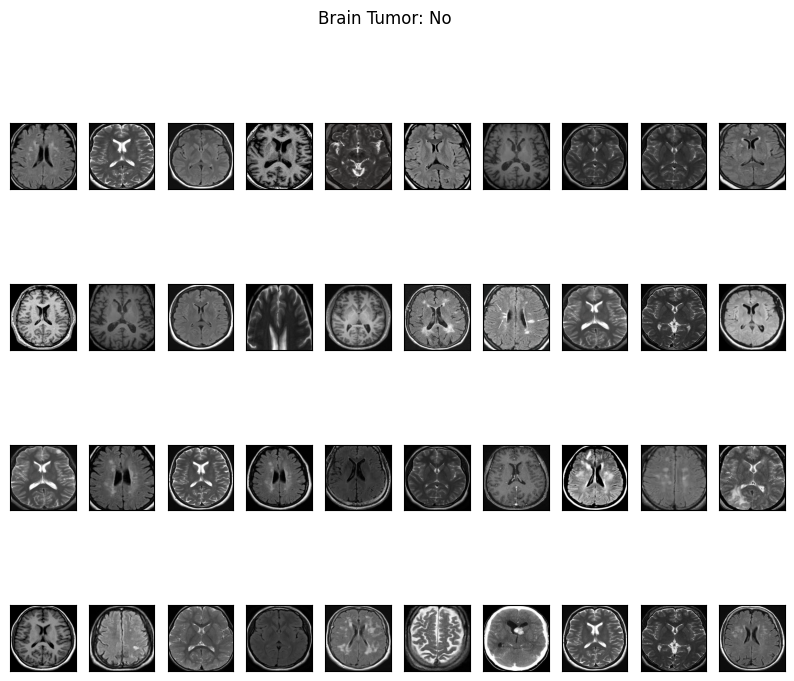

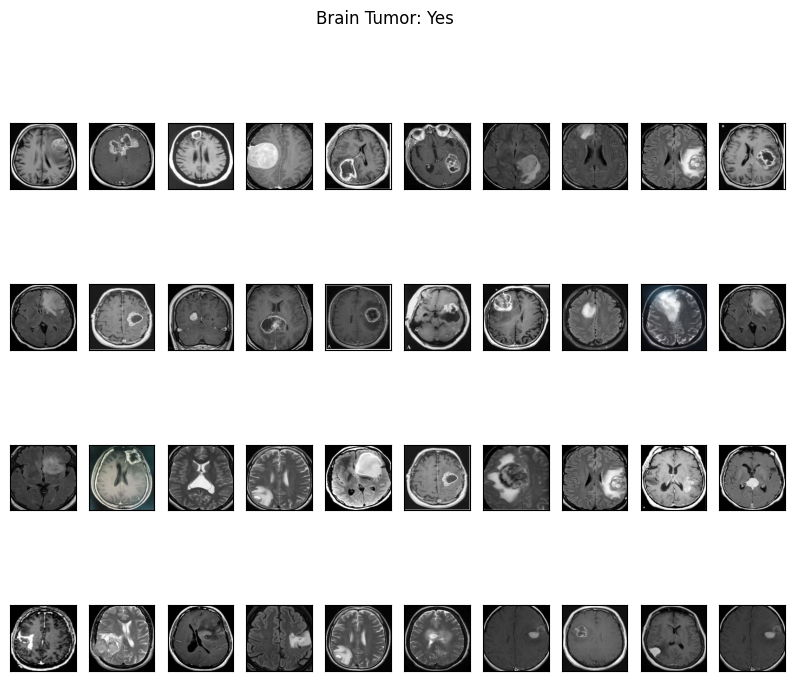

In [ ]:
# Define paths to image directories

image_dir = '/content/brain_tumor_mri/brain_tumor_dataset'
yes_tumor_dir = os.path.join(image_dir, 'yes')
no_tumor_dir = os.path.join(image_dir, 'no')

image_size = (240, 240)

X, y = load_data([yes_tumor_dir, no_tumor_dir], image_size)


plot_sample_images(X, y)

Data Splitting Function

In [ ]:
from sklearn.model_selection import train_test_split


def split_data(X, y, test_size=0.2):

    """
    Splits data into training, validation, and testing sets.

    Args:
        X: The input data.
        y: The target data.
        test_size: The proportion of the dataset to include in the test split.

    Returns:
        The split datasets.
    """
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test




Data Splitting Execution

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

Printing the number of examples in each set

In [ ]:

print("number of training examples = " + str(X_train.shape[0]))
print("number of validation examples = " + str(X_val.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))



number of training examples = 177
number of validation examples = 38
number of test examples = 38


Model Architecture Definition

In [ ]:
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs = X_input, outputs = X)

    return model

Model Initialization and Summary

In [ ]:
IMG_WIDTH = 240
IMG_HEIGHT = 240
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 238, 238, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 238, 238, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 238, 238, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Model Compilation and Training

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.5057 - loss: 1.7425 - val_accuracy: 0.5526 - val_loss: 0.6544
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.6205 - loss: 0.8920 - val_accuracy: 0.5526 - val_loss: 0.6930
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.5830 - loss: 0.7162 - val_accuracy: 0.5526 - val_loss: 0.6536
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6992 - loss: 0.5370 - val_accuracy: 0.6053 - val_loss: 0.6392
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.8223 - loss: 0.4708 - val_accuracy: 0.6579 - val_loss: 0.6387
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.8147 - loss: 0.3929 - val_accuracy: 0.6579 - val_loss: 0.6422
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.8465 - loss: 0.3849 - val_accuracy: 0.6053 - val_loss: 0.6395
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.9107 - loss: 0.3010 - val_accuracy: 0.6053 - val_loss: 0.6313
Epoch 9/

Training History Retrieval

In [ ]:
history = model.history.history

Metrics Visualization Function

In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

Metrics Visualization Execution

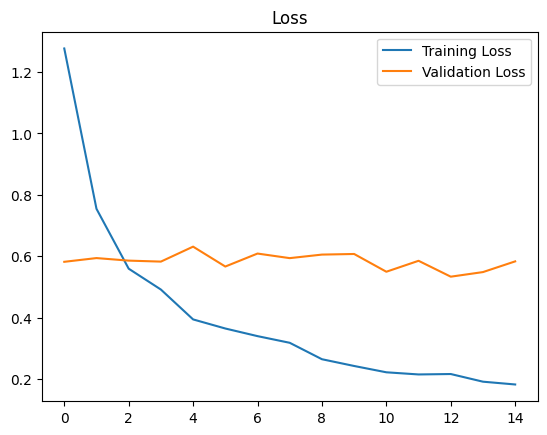

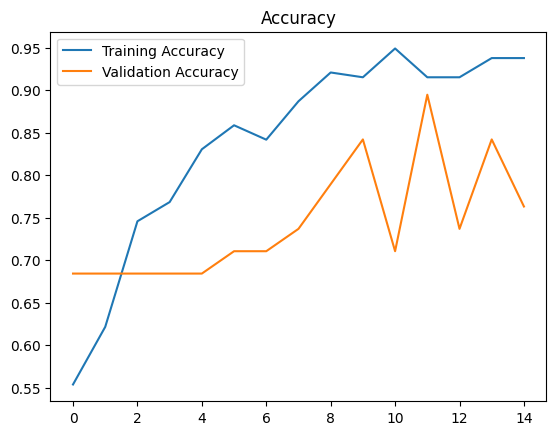

In [ ]:
plot_metrics(history)